# Model Training: Logistic Regression & XGBoost for Impaired Driving Prediction

**Objective:** Train models to predict driver impairment (`IMPAIRED`) based on accident characteristics.

**Steps:**
1. Load Preprocessed Data
2. Feature Engineering (Risk Scores)
3. Data Splitting
4. Preprocessing Pipelines (Imputation, Scaling, Encoding)
5. Train Logistic Regression (Baseline)
6. Train XGBoost (Advanced)
7. Evaluation & Comparison

NOTE: This is an early sketch for a future model-training pipeline. It currently uses Logistic Regression and XGBoost trained on a set of features selected based on Random Forest feature-importance scores. The implementation still needs substantial improvement, and at the moment it relies exclusively on 2023 data. Most of the code was auto-generated and lacks proper documentation.

The accuracy is very low (only 70%, which might get better with more data and features).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

from config import Config

# 1. Load Data
data_path = Config.FARS_CLEANED_DIR / "fars_model_ready.pkl"
df = pd.read_pickle(data_path)

#Optimize datatypes
df = df.convert_dtypes()

for col in df.select_dtypes(include=['number']):
    df[col] = pd.to_numeric(df[col], downcast='integer')
    if df[col].dtype == 'float64':
        df[col] = pd.to_numeric(df[col], downcast='float')

# 2. Initial Cleanup: Drop ID and Leakage Columns
cols_to_drop = ['ST_CASE', 'DRUNK_DRIVERS', 'DRIVERS_ON_DRUGS', 'RAIL', 'HOUR', 'MINUTE']
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

print(f"Data Shape after cleanup: {df_clean.shape}")

Data Shape after cleanup: (105060, 41)


In [2]:
# 3. Split Data (Train/Test)
# Splitting MUST happen before Target Encoding to prevent data leakage.
X = df_clean.drop(columns=['INTOXICATED_DRIVER_INVOLVED'])
y = df_clean['INTOXICATED_DRIVER_INVOLVED']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")

Training Set: (84048, 40)
Test Set: (21012, 40)


In [3]:
# 4. Feature Engineering: Risk Scores (Target Encoding)
def create_risk_scores(train_df, test_df, y_train, cols_to_encode):
    train_eng = train_df.copy()
    test_eng = test_df.copy()
    
    # Temporary DF for mapping
    train_temp = train_eng.copy()
    train_temp['TARGET'] = y_train
    
    global_rate = y_train.mean()
    
    for col in cols_to_encode:
        # Calculate risk per category on TRAIN data
        risk_map = train_temp.groupby(col)['TARGET'].mean()
        
        # Create new feature
        new_col = f"{col}_risk_score"
        
        # Map to Train and Test (Fill unknown categories with global mean)
        train_eng[new_col] = train_eng[col].map(risk_map).ffill()
        test_eng[new_col] = test_eng[col].map(risk_map).ffill()
        # train_eng[new_col] = train_eng[col].map(risk_map).fillna(global_rate)
        # test_eng[new_col] = test_eng[col].map(risk_map).fillna(global_rate)
        
        # Drop original high-cardinality text column
        train_eng = train_eng.drop(columns=[col])
        test_eng = test_eng.drop(columns=[col])
        
    return train_eng, test_eng

# Select High-Cardinality Columns for Risk Scoring
high_card_features = ['STATENAME', 'ROUTENAME', 'HARM_EVNAME', 'MAN_COLLNAME']

# Apply Engineering
print("Engineering Risk Scores...")
X_train_eng, X_test_eng = create_risk_scores(X_train, X_test, y_train, high_card_features)

print(f"New Features: {X_train_eng.columns.tolist()}")

Engineering Risk Scores...
New Features: ['PEDS', 'PERNOTMVIT', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PERSONS', 'PERMVIT', 'COUNTYNAME', 'MONTH', 'DAY', 'DAY_WEEKNAME', 'YEAR', 'TWAY_ID', 'RUR_URBNAME', 'FUNC_SYSNAME', 'RD_OWNERNAME', 'NHSNAME', 'SP_JURNAME', 'RELJCT2NAME', 'TYP_INTNAME', 'REL_ROADNAME', 'WRK_ZONE', 'LGT_CONDNAME', 'WEATHERNAME', 'SCH_BUSNAME', 'NOT_HOUR', 'NOT_MIN', 'ARR_HOUR', 'ARR_MIN', 'HOSP_HR', 'HOSP_MN', 'FATALS', 'TOTAL_HARM', 'IS_RAIL_CROSSING', 'HOUR_SIN', 'HOUR_COS', 'STATENAME_risk_score', 'ROUTENAME_risk_score', 'HARM_EVNAME_risk_score', 'MAN_COLLNAME_risk_score']


C:\Users\aarth\AppData\Local\Temp\ipykernel_12444\4056248786.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_map = train_temp.groupby(col)['TARGET'].mean()


In [4]:
# 5. Define Preprocessing Pipeline
# We must re-identify columns because the dataframe structure changed.

cat_cols = X_train_eng.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train_eng.select_dtypes(include=['number']).columns.tolist()

print(f"Numerical Features: {len(num_cols)}")
print(f"Categorical Features: {len(cat_cols)}")

# Numeric Pipeline: Impute -> Scale
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Pipeline: Impute -> OneHot
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ],
    verbose_feature_names_out=False
)

Numerical Features: 24
Categorical Features: 9


In [5]:
# 6. Train Logistic Regression
print("\n--- Training Logistic Regression ---")
lr_model = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
lr_model.fit(X_train_eng, y_train)

# Evaluate
y_pred_lr = lr_model.predict(X_test_eng)
y_prob_lr = lr_model.predict_proba(X_test_eng)[:, 1]

print(classification_report(y_test, y_pred_lr))
print(f"Logistic Regression ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")


--- Training Logistic Regression ---
              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78     13499
         1.0       0.61      0.48      0.53      7513

    accuracy                           0.70     21012
   macro avg       0.67      0.65      0.66     21012
weighted avg       0.69      0.70      0.69     21012

Logistic Regression ROC-AUC: 0.7552


In [6]:
# 7. Train XGBoost
print("\n--- Training XGBoost ---")
# Calculate class weight for imbalance
pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=pos_weight,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])
xgb_model.fit(X_train_eng, y_train)

# Evaluate
y_pred_xgb = xgb_model.predict(X_test_eng)
y_prob_xgb = xgb_model.predict_proba(X_test_eng)[:, 1]

print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost ROC-AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")


--- Training XGBoost ---


C:\Users\aarth\AppData\Local\Temp\ipykernel_12444\3521191709.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
C:\Users\aarth\AppData\Local\Temp\ipykernel_12444\3521191709.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
a:\Documents\Aarthi\Uni\Lisbon\Y1\Foundations of Data Science\Project\US_accidents_project\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:13:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encod

              precision    recall  f1-score   support

         0.0       0.84      0.61      0.71     13499
         1.0       0.53      0.79      0.63      7513

    accuracy                           0.67     21012
   macro avg       0.68      0.70      0.67     21012
weighted avg       0.73      0.67      0.68     21012

XGBoost ROC-AUC: 0.7817


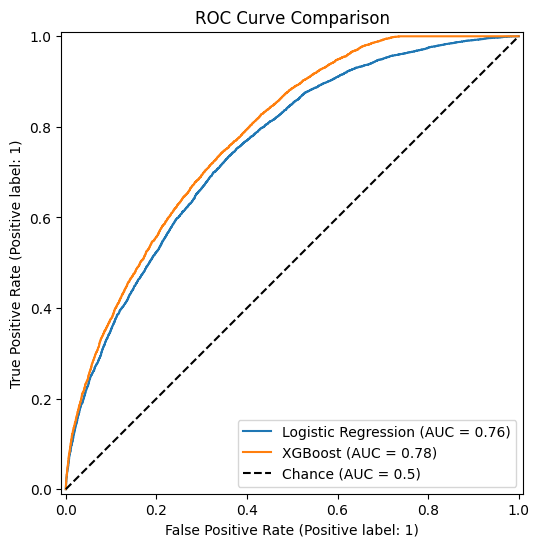

In [7]:
# 8. Compare ROC Curves
fig, ax = plt.subplots(figsize=(10, 6))
RocCurveDisplay.from_estimator(lr_model, X_test_eng, y_test, ax=ax, name="Logistic Regression")
RocCurveDisplay.from_estimator(xgb_model, X_test_eng, y_test, ax=ax, name="XGBoost")
plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.5)")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()